**<span style="color:crimson;">Context**
    
Demand forecasting is the process of predicting what the demand for certain products will be in the future. This helps manufacturers to decide what they should produce and guides retailers toward what they should stock.
    

Demand forecasting is aimed at improving the processes of Supplier relationship management, Customer relationship management, Order fulfillment and logistics and Marketing campaigns. 

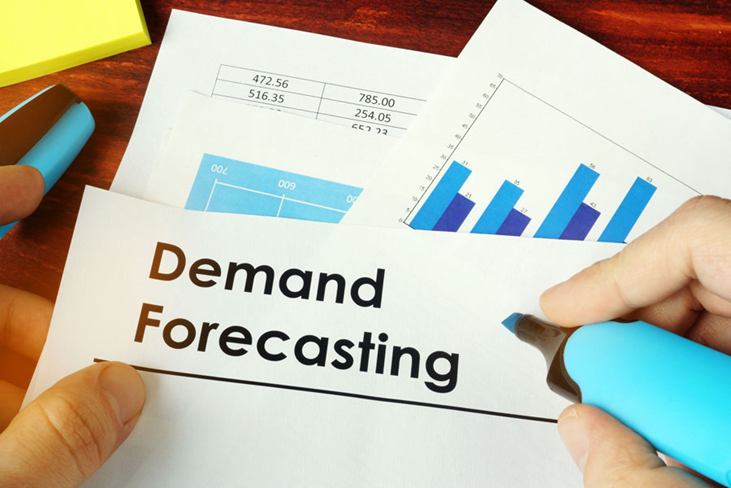

**<span style="color:crimson;">Business Problem**
    
Create a 3-month demand forecasting model for the relevant retailer using the time series and machine learning techniques.  
The data set includes 5 years of data for 10 different stores and 50 different products of a chain of stores between 2013–01–01 and  2017–12–31.

**<span style="color:crimson;">Task Details**
    
* [1. IMPORTING LIBRARIES AND DATA](#section-one)
* [2. EXPLORATORY DATA ANALYSIS](#section-two)
* [3. FEATURE ENGINEERING & DATA PRE-PROCESSING](#section-three)
    * [3.1 Date Features](#sub_section-3.1)
    * [3.2 Random Noise](#sub_section-3.2)
    * [3.3 Lag/Shifted Features](#sub_section-3.3)
    * [3.4 Rolling Mean Features](#sub_section-3.4)
    * [3.5 Exponentially Weighted Mean Features](#sub_section-3.5)
    * [3.6 One-Hot Encoding](#sub_section-3.6)
    * [3.7 Converting sales to log(1+sales)](#sub_section-3.7)

    
    
* [4. MODEL](#section-four)
    * [4.1 Time-Based Validation Sets](#sub_section-4.1)
    * [4.2 LightGBM Model](#sub_section-4.2) 
    * [4.3 Feature Importance](#sub_section-4.3)
    * [4.4 Final Model](#sub_section-4.4)     
    
    
* [5. SUBMISSION](#section-five)


**<span style="color:crimson;">Variables**
   
* **date :**  Date of sales data
* **store :** Unique Store ID for each store.
* **item :**  Unique Item ID for each item.
* **sales :** The number of items sold from a particular store on a given date.
 




# <span style="color:crimson;">1. IMPORTING LIBRARIES AND DATA

In [ ]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
#sample_sub = pd.read_csv('./input/demand-forecasting-kernels-only/sample_submission.csv')
df = pd.concat([train, test], sort=False)


<a id="section-two"></a>
# <span style="color:crimson;"> 2. EXPLORATORY DATA ANALYSIS   

In [ ]:
df["date"].min(), df["date"].max()

The data starts from the 1st of the 1st month of 2013. It goes until the 31st of the 3rd month of 2018.


In [ ]:
train.shape, train.dtypes

In [ ]:
test.shape, test.dtypes

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

In [ ]:
df.head(),df.tail()

On January 1, 2013, 13 items of item 1 were sold in the 1st store. 
On another date, there was no sale of the item 50 in the store no. 10.

In [ ]:
# How is sales distribution?
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

In [ ]:
# How many stores are there?
df[["store"]].nunique()

In [ ]:
# How many items are there?
df[["item"]].nunique()

In [ ]:
# How many unique items are in each store?
df.groupby(["store"])["item"].nunique()

In [ ]:
# Are there equal numbers of sales in each store?
df.groupby(["store"]).agg({"sales": ["sum"]})

In [ ]:
# Sales statistics in store-item breakdown
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

<a id="section-two"></a>
# <span style="color:crimson;"> 3. FEATURE ENGINEERING

<a id="section-3.1"></a>
# <span style="color:crimson;"> 3.1 Date Features

In [ ]:
df['month'] = df.date.dt.month
df['day_of_month'] = df.date.dt.day
df['day_of_year'] = df.date.dt.dayofyear
df['week_of_year'] = df.date.dt.weekofyear
df['day_of_week'] = df.date.dt.dayofweek
df['year'] = df.date.dt.year
df["is_wknd"] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)

df.head()

Now that we have the month information, we can advance the descriptive analysis.

In [ ]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

At the moment, I have access to information about how much is sold in which store, from which item, in which month.

<a id="section-3.2"></a>
# <span style="color:crimson;"> 3.2 Random Noise

We add random values that are as large as the size of the dataframe to the new features we will create.  
Adding noise here prevents overfitting. It increases our prediction performance.

In [ ]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

<a id="section-3.3"></a>
# <span style="color:crimson;"> 3.3 Lag/Shifted Features

We will be producing features related to the sales numbers of the past period.  
Lag means delay. Shifted is also used in the same sense.  

The time period t was most affected by t-1, sequentially from t-2.  
So we assume that the next day's sale of a store is affected by the previous day's sale, so we will need to derive features for that.  
These features will also create the values of the sales variable in previous periods.  
To do this, the data must be ordered according to store, item and date so that we can produce these features correctly.

In [ ]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

df.head()

In [ ]:
df.groupby(["store", "item"])['sales'].head()

Let's apply a delay of 1 to the whole dataset. So we calculated 1 lag of each value.

In [ ]:
df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))

Let's write a function for this.
We will give the Dataframe to this function, we will set the delays we want.
It will travel in delays. It will calculate the 30-day, 60-day, 90-day delay and add it to the dataframe as a new variable in order.
It will add that into the dataframe, adding noise to it.

In [ ]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

Our main goal is to catch the trend, seasonality and level.  
Since this is a 3-month period, we have added it here as multiples of 3 months, 3 months +1 week, 3 months + 2 weeks, 6 months, etc.

In [ ]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

df.head()

<a id="section-3.4"></a>
# <span style="color:crimson;"> 3.4 Rolling Mean Features

This is the moving average. If I'm going to make predictions in a 3-month period, I need to show the patterns 3 months before that to my model.

In [ ]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

In [ ]:

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})


In [ ]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])
df.tail()


<a id="section-3.5"></a>
# <span style="color:crimson;"> 3.5 Exponentially Weighted Mean Features

Here, as an example, I put a rolling mean and a weighted average with alpha values of 0.99, 0.95, 0.7 and 0.1.

The weighted average would give more weight to the closest values when the Alpha was 0.99, and would give more weight to the farthest values when it was 0.1.

In [ ]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm01": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

When we take the exponential average of the 2 lags of 14, when we say give 0.99 weight to 11, 11.019802 is found. It's getting closer to 13 for 0.1.
In fact, while the average of these two with the moving average is 12, when we say give weight to this first with alpha, the average changes.

Let's give lags and alphas as a combination to accommodate the influence of past periods.  
When we use lightgbm later, we will be waiting to see if features are produced against combinations such as Lag 91 & Alpha 0.95 or Lag 98 & Alpha 0.7 and which ones will be more meaningful.

In [ ]:

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

df.tail()

In [ ]:
df.shape

In the beginning we had 4 variables

<a id="section-3.6"></a>
# <span style="color:crimson;"> 3.6 One-Hot Encoding

In [ ]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])
df.shape

The number of variables increased from 71 to 146.

<a id="section-3.7"></a>
# <span style="color:crimson;"> 3.7 Converting sales to log(1+sales)

In [ ]:
df['sales'] = np.log1p(df["sales"].values)
df.head()

<a id="section-four"></a>
# <span style="color:crimson;"> 4. MODELLING   


Submissions are evaluated in this competition on SMAPE (Symmetric mean absolute percentage error (adjusted MAPE)) so we will define a function in order to evaluate the difference between forecasts and actual values.  
When we use SMAPE it allows us to evaluate an error as a percentage

In [ ]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In summary, our cost functioncompares the estimated values with the actual values. It then takes their absolute values and converts them to percentage form.


In [ ]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


We also define a lgbm_smape function to optimize the lightgbm function accordingly.
We need to translate this custom cost function into the language that lightgbm understands. We have done a logarithmic transformation before. We will have the opportunity to apply this to the smape function, which will also undo this logarithmic transformation.

<a id="section-4.1"></a>
# <span style="color:crimson;"> 4.1 Time-Based Validation Sets

Kaggle asks us to predict the first 3 months of 2018 in the test set. The train set is between January 2013 and December 2017.

I need to do something like that, I have to create 2 sets within the set given to me as a train set.  
One must be train and the other must be validation.   
When we randomly divide the train and validation sets, our date context will be broken, so we need to manually separate the train and validation sets, not randomly.

Let's create our train set until the beginning of 2017, and let's take the first 3 months of 2017 as a validation set.

In [ ]:
train = df.loc[(df["date"] < "2017-01-01"), :]

val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape



<a id="section-4.2"></a>
# <span style="color:crimson;"> 4.2 LightGBM Model

In [ ]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}


lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

In the 1000th iteration, the smallest value is reached. Our error is 13,8248 %.

For example, if I said that an item in 1 store will sell 100 units in the future 3-month period, it may be 113,8248 units, it may be 86,1752 units, so I have a 13,8248 % margin of error.  
We made a guess, but we haven't set up the final model where the best iteration is set yet.

<a id="section-4.3"></a>
# <span style="color:crimson;"> 4.3 Feature Importance

In [ ]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

plot_lgb_importances(model, num=30, plot=True)

plt.show()

Our newly derived features are at the top of the ranking.

<a id="section-4.3"></a>
# <span style="color:crimson;"> 4.3 Final Model

When we focus on NaN values of 'sales' in the dataframe, we know that this will correspond to the test set.  
We brought together 2 dataframes, in which the train set with sales parts and the test set without.

In [ ]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}


# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

test_preds = model.predict(X_test, num_iteration=model.best_iteration)



<a id="section-5"></a>
# <span style="color:crimson;"> 5 Submission

In [ ]:
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv('submission.csv', index=False)
submission_df.head()
